In [2]:
from tqdm import tqdm
from natsort import natsorted
import os
from IPython.display import Audio
import librosa
import copy
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

path = './'
dataset_path = f'{path}/SpeechCommands/speech_commands_v0.02'
img_path = f'{path}/wav_to_img'

# listdir을 정렬하기
def listdir(path):
    return natsorted(os.listdir(path))

# 폴더 만들어주는 함수
def makedirs(path):
    os.makedirs(path, exist_ok = True)

# listdir을 하는데 폴더만 걸러내는 로직(class list 만드는데 사용)
def only_folder(path):
    file_list = listdir(path)
    folder_list = []
    for file in file_list:
        if os.path.isdir(f'{dataset_path}/{file}') == True:
            folder_list.append(file)
    return folder_list

# 오디오 길이 맞춰주는 함수
def process_audio(audio_path):
    data, sr = librosa.load(audio_path, sr=None) # 오디오를 원본 샘플링 레이트로 로드
    # 목표 길이 설정 (1초)
    target_length = sr  # 1초에 해당하는 샘플 수
    current_length = len(data) # 현재 데이터 길이
    if current_length > target_length: # 1초를 초과하면 뒷부분을 잘라냄
        data = data[:target_length] 
    elif current_length < target_length: # 1초 미만이면 무음을 추가
        padding = np.zeros(target_length - current_length)
        data = np.concatenate((data, padding))
    return data, sr

# 오디오를 스팩트로그램으로 만들기
def wav_to_spectrogram(audio_data, sr, display):
    # n_mels 값을 224로 설정하여 세로 크기 조정
    n_mels = 224
    # 오디오 데이터의 길이가 1초, 샘플링 레이트가 16000Hz이므로, 총 샘플 수는 16000개
    total_samples = len(audio_data)  # 이 경우 16000으로 가정
    target_width = 224
    # 가로 크기를 224에 맞추기 위한 hop_length 계산
    hop_length = int(np.floor(total_samples / (target_width - 1)))
    # 멜 스펙트로그램 계산
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, fmax=sr/2, hop_length=hop_length)
    log_S = librosa.power_to_db(S, ref=np.max)  # 로그 스케일로 변환
    # 이미지 데이터로 변환 (정규화)
    img = (log_S - log_S.min()) / (log_S.max() - log_S.min()) * 255.0
    img = img.astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    # 이미지 리사이징 (옵셔널, 정확한 크기 조정을 위해)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    if display == True:
        print(f'img shape: {img.shape}')
        # 추가: matplotlib을 사용하여 이미지 표시 (옵션)
        plt.figure(figsize=(5, 4))
        plt.imshow(img, aspect='auto', origin='lower')
        plt.title('Mel-spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Mel bands')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
    return img

### class list 정의하기

In [3]:
class_list = only_folder(dataset_path)
print(class_list)
len_class = len(class_list)
print(f'len_class: {len_class}')

['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
len_class: 36


### 데이터 전처리

오디오 이름: marvin/1c76f5f3_nohash_0.wav
오디오 길이: 1.0초
data 길이: 16000
img shape: (224, 224, 3)


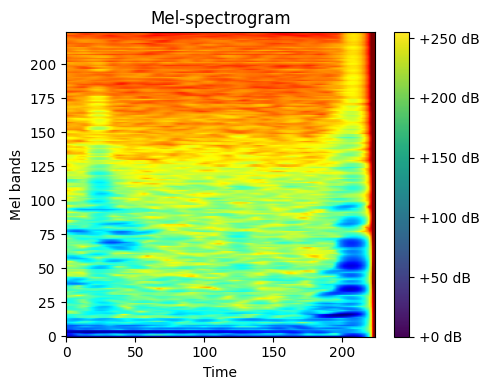

In [6]:
# 랜덤한 음성 들어보기
random_class = copy.deepcopy(class_list)
random.shuffle(random_class)
random_class = random_class[0]
# random_class = 'marvin'
audio_list = listdir(f'{dataset_path}/{random_class}')
random.shuffle(audio_list)
random_audio = audio_list[0]
print(f'오디오 이름: {random_class}/{random_audio}')
audio_path = f'{dataset_path}/{random_class}/{random_audio}'
data, sr = process_audio(audio_path)
# data, sr = librosa.load(audio_path, sr=None)
audio_len = len(data) / sr
print(f'오디오 길이: {audio_len}초')
print(f'data 길이: {len(data)}')
img = wav_to_spectrogram(data, sr, display = True)
Audio(data, rate = sr)

In [5]:
# train, val, test 셋 정의

# 텍스트 파일을 리스트로 가져오는 함수
def txt_to_list(path):
    with open(path, 'r') as f:
        full_txt = f.read()
    txt_list = full_txt.split('\n')
    if txt_list[-1] == '':
        del txt_list[-1]
    return txt_list

val_list = txt_to_list(f'{dataset_path}/validation_list.txt') # val 리스트
test_list = txt_to_list(f'{dataset_path}/testing_list.txt') # test 리스트

# train list 만들기
train_list = []
for class_name in tqdm(class_list):
    audio_list = listdir(f'{dataset_path}/{class_name}')
    for audio_name in audio_list:
        if not '.wav' in audio_name: continue # 오디오 파일만 받겠다
        audio_path = f'{class_name}/{audio_name}'
        if audio_path in val_list or audio_path in test_list: continue # val과 test 리스트에 겹치지 않는 오디오를 모두 train_list에 추가
        train_list.append(audio_path)

print(f'train list 길이: {len(train_list)}')
print(f'val list 길이: {len(val_list)}')
print(f'test list 길이: {len(test_list)}')

100%|██████████| 36/36 [00:19<00:00,  1.88it/s]

train list 길이: 84849
val list 길이: 9981
test list 길이: 11005


In [7]:
# wav를 이미지로 바꾸어 저장

# 폴더 생성
for mode in ['train', 'val', 'test']:
    for class_name in class_list:
        makedirs(f'{img_path}/{mode}/{class_name}')

# 이미지로 변환    
error_list = ['에러코드 모음\n']
for class_name in class_list:
    audio_list = listdir(f'{dataset_path}/{class_name}')
    for audio_name in tqdm(audio_list):
        try:
            if not '.wav' in audio_name: continue # 오디오 파일만 처리(readme 등 제외)
            data, sr = process_audio(f'{dataset_path}/{class_name}/{audio_name}') # 오디오 읽기
            img = wav_to_spectrogram(data, sr, display = False) # 이미지로 변환
            img_name = f'{audio_name[:-4]}.png'
            # train, val, test 분류
            audio_path = f'{class_name}/{audio_name}'
            if audio_path in train_list:
                mode = 'train'
            elif audio_path in val_list:
                mode = 'val'
            elif audio_path in test_list:
                mode = 'test'
            else:
                print('어디에도 속하지 않아 train으로 이동')
                mode = 'train'
            cv2.imwrite(f'{img_path}/{mode}/{class_name}/{img_name}', img) # 이미지 저장
        except Exception as e:
            error_list.append(f'{audio_name}: {e}')
            print(error_list)

 11%|█         | 444/4052 [00:08<01:05, 55.20it/s]


KeyboardInterrupt: 

### YOLOv8 Classifier 학습

In [212]:
# YOLOv8 Classifier 모델 학습

# 아래 명령어 터미널에 입력하여 학습 진행
'''
from ultralytics import YOLO
model = YOLO("D:/Code/240220_wakeup_test/yolov8x-cls.pt")
model.train(epochs = 100, data = "./wav_to_img", save_period = 5, batch = 32, imgsz = 224, auto_augment = False, augment = False, mosaic = 1.0, mixup = 0.0, erasing = 0, scale
 = 0, fliplr = 0)
'''


New https://pypi.org/project/ultralytics/8.1.16 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.199  Python-3.8.18 torch-1.10.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=classify, mode=train, model=.//yolov8x-cls.pt, data=.//wav_to_img, epochs=100, patience=50, batch=32, imgsz=224, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_

### 학습 결과

CNN은 별로 안좋은 듯

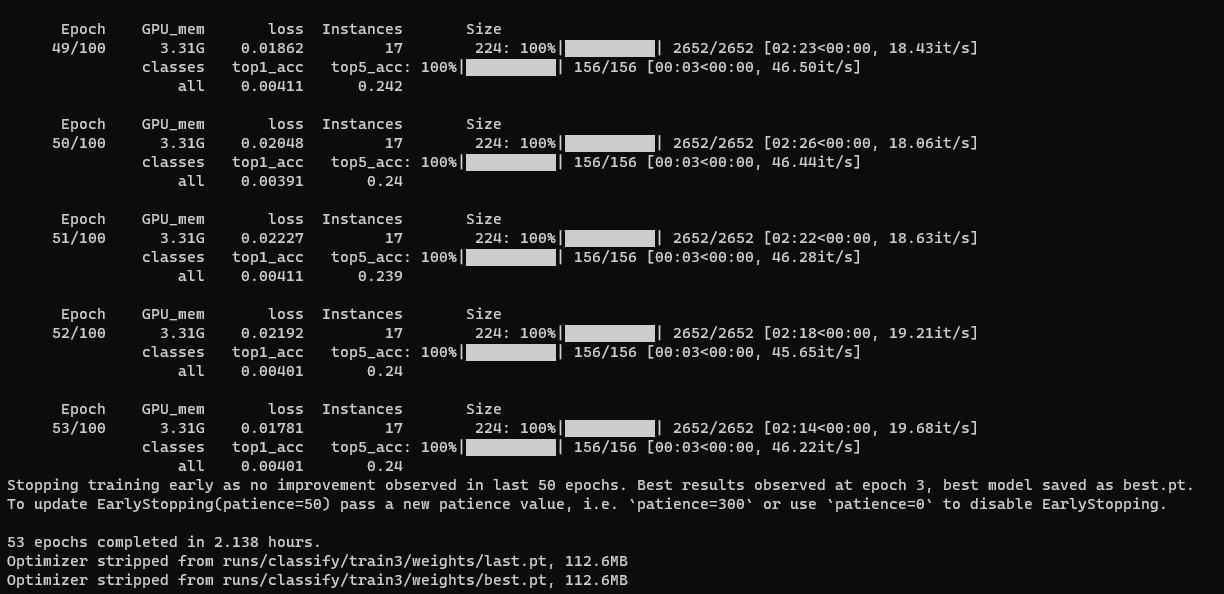